# Stacking Calibrated Images with Alignment Option

This notebook:
- Calibrates images for each filter (g, r, i)
- Subtracts bias and dark, divides by flat
- Aligns images if `align_images = True`
- Combines images using median to create a final stack

In [7]:
import numpy as np
from astropy.io import fits
from pathlib import Path
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
import matplotlib.pyplot as plt

# -----------------------------
# User settings
# -----------------------------
filters = ['g', 'r', 'i']
align_images = True  # Activate or deactivate image alignment

# Chemins
bias_path = Path('master_bias_23.fits')
darks_dir = Path('master_darks_23/')
flats_dir = Path('master_flats_23')
raw_dir = Path('/Volumes/Astro/ohp/CANAGUIER_LOUSTALET_SAPHORES/test')  # contient g/, r/, i/
output_dir = Path('stacks/')
output_dir.mkdir(exist_ok=True)

In [8]:
# Load master bias
master_bias = fits.getdata(bias_path).astype(np.float32)

def load_master_dark(exptime):
    path = darks_dir / f'master_dark_{exptime}s.fits'
    if path.exists():
        return fits.getdata(path).astype(np.float32)
    else:
        print(f"No, master_dark_{exptime}s.fits , dark ignored.")
        return np.zeros_like(master_bias)

def load_master_flat(filter_name):
    path = flats_dir / f'master_flat_{filter_name}.fits'
    if path.exists():
        return fits.getdata(path).astype(np.float32)
    else:
        raise FileNotFoundError(f"Master flat left for {filter_name}")

# Application des calibrations
$OUTPUT = \frac{INPUT - DARK - BIAS}{FLAT}$


Filter g — 21 images
Stack saved: stacks/stack_g.fits


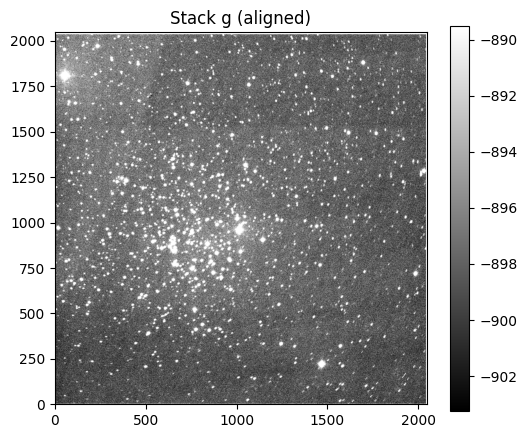


Filter r — 21 images
Stack saved: stacks/stack_r.fits


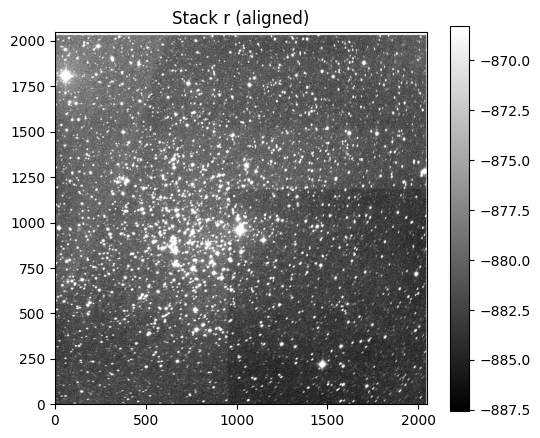


Filter i — 16 images
Stack saved: stacks/stack_i.fits


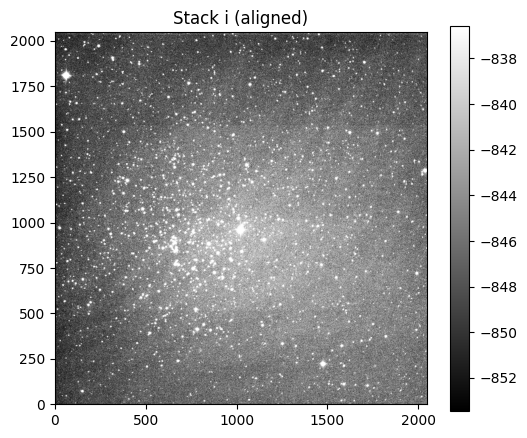

In [9]:
# Loop over filters
for f in filters:
    subdir = raw_dir / f
    files = sorted(subdir.glob('M*.fits'))
    if len(files) == 0:
        print(f"No files found for filter {f}")
        continue

    print(f"\nFilter {f} — {len(files)} images")

    master_flat = load_master_flat(f)
    calibrated_images = []
    ref_image = None

    for i, file in enumerate(files):
        with fits.open(file, ignore_missing_end=True) as hdul:
            data = hdul[0].data.astype(np.float32)
            header = hdul[0].header
            exptime = int(hdul[0].header.get('EXPTIME', None))
            
            # Calibration basique
            master_dark = load_master_dark(5) if exptime else np.zeros_like(data)
            calibrated = (data - master_bias - master_dark) #/ master_flat
            #calibrated  = data

            # Alignement
            if align_images:
                if ref_image is None:
                    ref_image = calibrated
                    calibrated_images.append(calibrated)
                    continue
                shift_estimate, error, _ = phase_cross_correlation(ref_image, calibrated, upsample_factor=10)
                aligned = shift(calibrated, shift_estimate)
                calibrated_images.append(aligned)
            else:
                calibrated_images.append(calibrated)

    stack = np.median(np.array(calibrated_images), axis=0)
    out_path = output_dir / f'stack_{f}.fits'
    fits.writeto(out_path, stack.astype(np.float32), overwrite=True, header=header)
    print(f"Stack saved: {out_path}")

    plt.figure(figsize=(6,5))
    plt.imshow(stack, origin='lower', cmap='gray',
               vmin=np.percentile(stack, 5), vmax=np.percentile(stack, 95))
    plt.title(f'Stack {f} ({'aligned' if align_images else 'not aligned'})')
    plt.colorbar()
    plt.show()